## DATA5709 Capstone Project
# **Portfolio Optimization with Deep Reinforcement Learning**

Tae Wan, Kim (tkim0934)

# 1 - Packages

In [0]:
!pip install -q yfinance
!pip install -q empyrical
# data handling
import yfinance
import numpy as np
import pandas as pd
from pandas_datareader import data
from collections import deque
from scipy.optimize import minimize
from empyrical import sharpe_ratio, sortino_ratio, calmar_ratio

# reinforcement/deep learning
import gym
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense, Flatten, Reshape, concatenate
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.activations import relu, elu, sigmoid, tanh
from tensorflow.keras.initializers import RandomNormal, RandomUniform

# miscellaneous
import sys
import logging
import os.path
import random
import threading
import time
from datetime import datetime
from enum import Enum
from abc import abstractmethod
from tqdm.notebook import tqdm

yfinance.pdr_override()
logging.basicConfig(stream=sys.stderr, level=logging.INFO)
PATH = './drive/My Drive/Colab Notebooks/Prj/'

# decorator for partially defined class functions
def partial_class(partial_class):
    def decorator(func):
      setattr(partial_class, func.__name__, func)
      return func
    return decorator

     |████████████████████████████████| 51kB 3.6MB/s 


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# 2 - Data Provider

## 2.1. Main Class
`AssetData` class was implemented to provide OHLC (Open, High, Low and Close) prices, volumes and bid-ask spreads data to the environment for every step in an episode (a sequence of consecutive steps made along with the interactions between the agent and environment). A set of data for a step which the agent can interpret to guess the current state is a data sequence with a fixed window size under the assumption of *Partially Observable Markov Decision Process* (Kaelbling et al., 1998)[[6](#scrollTo=cYmM0vHOpPwN)] in this project.


In [0]:
class AssetData(object):
    # define features to be included
    feats = {'Open': 0, 'High': 1, 'Low': 2, 'Close': 3, 'Volume': 4, 'Spread': 5}

    def __init__(self, assets, start_date, end_date, window, steps, asset_shuffle=False, include_cash=True):
        self.assets = assets
        self.start_date = start_date
        self.end_date = end_date
        # load each asset data
        for (i, asset) in enumerate(self.assets):
            if i == 0:
                df = self._load_data(asset)
            else:
                df = pd.merge(df, self._load_data(asset), on='Date', how='outer')
        self.dates = [date.strftime('%Y-%m-%d') for date in list(df.index)]
        self.data = np.array(df.sort_index().values.reshape(len(df), len(self.assets), -1), dtype='float32')
        self.window = window
        self.steps = steps if steps is not None else self.data.shape[0] - window - 1
        # generate cash data
        if include_cash:
            cash = np.ones((self.data.shape[0], 1, self.data.shape[2]))
            cash[:, :, -1] = 0  # zero spread for cash
            self.data = np.concatenate((cash, self.data), axis=1)
            self.assets = ['CASH'] + self.assets
        self.asset_index = [i for i in range(len(self.assets))]
        self.asset_shuffle = asset_shuffle
        self.reset()

    def __call__(self, step):
        assert step <= self.steps, f'The step({step}) should be less than or equal to total episode steps'
        observation = self.data[self.offset + step - self.window:self.offset + step + 1, self.asset_index, :].copy()
        date = self.dates[self.offset + step]
        return observation, date

    def reset(self):
        lower_bound = self.window
        upper_bound = self.data.shape[0] - self.steps - 1
        if lower_bound == upper_bound:
            self.offset = lower_bound
        else:
            self.offset = np.random.randint(low=lower_bound, high=upper_bound)
        if self.asset_shuffle:
            asset_index = [i+1 for i in range(len(self.assets)-1)]
            np.random.shuffle(asset_index)
            self.asset_index[1:] = asset_index

## 2.2. Data Acquisition
`_load_data` is a method of `AssetData` and loads designated asset data from cached files or from *Yahoo Finance* in real time. Since bid-ask spread data is not provided, the estimate from bid-ask from close, high and low prices (Abdi and Ranaldo, 2017)[[1](#scrollTo=cYmM0vHOpPwN)] is adopted. The measure for the proportional bid-ask spread is:
$$Spread = 2\sqrt{\mathbb{E}[(c_t-\eta_t)(c_t-\eta_{t+1})]}$$
in which $c$ is the daily close log-price and $\eta$ is the daily mid-range, that is, the average of daily high and low log-prices.

In [0]:
@partial_class(AssetData)
def _load_data(self, asset):
    # load data from a file if there's any
    file_name = PATH + f'Data/{asset}_{self.start_date}_{self.end_date}.csv'
    if os.path.isfile(file_name):
        df = pd.read_csv(file_name, header=[0, 1], index_col=0)
        df.index = pd.to_datetime(df.index)
        return df
    # download data from Yahoo Finance
    print(f'downloading {asset} data from Yahoo Finance')
    df = data.get_data_yahoo(asset, self.start_date, self.end_date)
    desired_date = datetime.strptime(self.start_date, '%Y-%m-%d')
    actual_date = df.iloc[0].name
    if actual_date > desired_date:
        print(f'WARNING: the start date of {asset} is {actual_date}!!')
    if 'Spread' in self.feats.keys():
        # estimate proportional bid-ask spread with log prices
        df['Eta'] = (np.log(df['High']) + np.log(df['Low'])) / 2
        df['Spread'] = 2 * np.sqrt(np.clip((np.log(df['Close'])-df['Eta']) * (np.log(df['Close'])-df['Eta'].shift(-1)), 0, None))
        df.iloc[-1, -1] = df.iloc[-2, -1]
    # build columns and indexes
    df = df[self.feats]
    pair_cols = [(asset, feat) for feat in df.columns]
    df.columns = pd.MultiIndex.from_tuples(pair_cols, names=['Asset', 'Field'])
    df.to_csv(file_name)
    return df

# 3 - Environment

## 3.1. Main Class
`AssetEnv` class was implemented using [*OpenAI Gym*](https://gym.openai.com/docs/), which is one of the most popular and widely used reinforcement learning framework. By subclassing `gym.Env` class, the module has standardized form that consists of `Reset`, `Step` and `Render` function. 

* **Reset**: In the beginning of every episode, the function is called and returns the initial observation.
* **Step**: With the action as its input, it returns a new observation, a reward for the action, and a flag that indicates the episode has finished or not.
* **Render**: Render function is for visualizing the information of current step in a customized way and can be called as much as needed.

In [0]:
class AssetEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, assets, start_date, end_date, window_size, episode_steps, 
                 return_type, reward_type, log_diff_prices=False, asset_shuffle=False,
                 init_balance=100000, tran_fee_rate=0.002, slippage_rate=0.5):
        super(AssetEnv, self).__init__()
        self.data = AssetData(assets, start_date, end_date, window_size, episode_steps, asset_shuffle)
        self.reward = AssetReward(return_type, reward_type)
        self.log_diff_prices = log_diff_prices
        self.init_balance = init_balance
        self.init_action = np.array([1.0] + [0.0]*len(assets))
        self.tran_fee_rate = tran_fee_rate
        self.slippage_rate = slippage_rate
        self.action_space = gym.spaces.Box(np.float32(0), np.float32(1), shape=(len(assets)+1,))  # including cash
        self.observation_space = gym.spaces.Box(np.float32(0), np.inf, shape=(self.data.window, len(assets)+1, len(self.data.feats)))

    def reset(self):
        self.current_step = -1
        self.infos = []
        self.data.reset()
        self.reward.reset()
        self.shares = self.init_balance * self.init_action
        self.portfolio_weights = np.tile(self.init_action, (self.data.window, 1))
        self.portfolio_values = self.init_balance * np.ones(self.data.window)
        observation, _, _, info = self.step(self.init_action)
        return observation, info

    def step(self, action):
        self.current_step += 1
        observation, cost = self._rebalance(action)
        reward = self.reward(self.portfolio_values[-self.current_step-2:])
        done = (self.portfolio_values[-1] <= 0) or (self.current_step >= self.data.steps)
        info = {
            'step': self.current_step,
            'date': self.date,
            'action': np.round(action, 3),
            'cost': round(cost, 2),
            'reward': round(reward, 2),
            'portfolio_weight': np.round(self.portfolio_weights[-1, :], 3),
            'portfolio_value': self.portfolio_values[-1]
        }
        self.infos.append(info)
        return observation, reward, done, info

    def render(self, mode='human', close=False):
        print(f'step: {self.current_step}')
        print(f'action: {self.infos[-1]["action"]}')
        print(f'portfolio_weight: {self.infos[-1]["portfolio_weight"]}')
        print(f'portfolio_value: {self.infos[-1]["portfolio_value"]}')

## 3.2. Rebalancing
`_rebalance` method was implemented for realistic portfolio environment as:
* The asset is rebalanced according to the integer values of shares.
* Transaction fee rate is considered and its default value was assumed conservatively at 20 basis points (0.2%)
* Slippage rate is adopted and its default value is half of the bid-ask spread.

In [0]:
@partial_class(AssetEnv)
def _rebalance(self, action):
    observation, date = self.data(self.current_step)
    self.date = date

    # rebalance asset shares - should be integer numbers
    current_price = observation[-1, :, self.data.feats['Close']]
    current_shares = self.shares
    current_value = np.dot(current_price, current_shares)
    rebal_shares = current_value * np.array(action) // current_price

    # apply transaction cost and slippage (excluding cash)
    bid_ask_spread = observation[-1, 1:, self.data.feats['Spread']]
    cost_rates = self.tran_fee_rate + (bid_ask_spread * self.slippage_rate)
    cost = (cost_rates * current_price[1:] * np.abs(current_shares[1:] - rebal_shares[1:])).sum()
    rebal_shares[0] = np.round((current_value - np.dot(current_price[1:], rebal_shares[1:]) - cost), 2)
    self.shares = rebal_shares

    # add new portfolio value
    portfolio_value = np.round(np.dot(current_price, self.shares), 2)
    self.portfolio_values = np.append(self.portfolio_values[1:], portfolio_value)

    # add new portfolio weight
    portfolio_weight = (current_price * self.shares) / np.dot(current_price, self.shares)
    self.portfolio_weights = np.append(self.portfolio_weights[1:, :], [portfolio_weight], axis=0)

    # differencing of log values (excluding spreads)
    if self.log_diff_prices:
        observation = np.diff(np.log(observation[:, :, :-1]), axis=0)
    else:
        observation[1:, :, self.data.feats['Volume']] = np.diff(np.log(observation[:, :, self.data.feats['Volume']]), axis=0)
        observation = observation[1:, :, :-1]
    new_feature = np.expand_dims(self.portfolio_weights, axis=2)
    observation = np.concatenate((observation, new_feature), axis=2).astype(np.float32)
    return observation, cost

## 3.3. Returns and Rewards

Several types and their calcuate functions were defined for returns and rewards. Most of reward functions were imported from `empyrical` package except *Differential Sharpe Ratio*, which was not implemented there.

In [0]:
class ReturnType(Enum):
    GROSS = 0
    NET = 1
    LOG = 2

    @classmethod
    def get_function(cls, return_type):
        funcs = {}
        funcs[cls.GROSS] = lambda values: (values[1:] / values[:-1])
        funcs[cls.NET] = lambda values: (values[1:] / values[:-1]) - 1
        funcs[cls.LOG] = lambda values: np.diff(np.log(values))
        return funcs[return_type]

class RewardType(Enum):
    DIFF_SHARPE = 0
    SHARPE = 1
    SORTINO = 2

    @classmethod
    def get_function(cls, reward_type):
        funcs = {}
        funcs[cls.DIFF_SHARPE] = None
        funcs[cls.SHARPE] = sharpe_ratio
        funcs[cls.SORTINO] = sortino_ratio
        return funcs[reward_type]

`AssetReward` class was implemented for general calculation of returns and rewards including *Differential Sharpe Ratio* (Moody and Saffell, 2001)[[8](#scrollTo=cYmM0vHOpPwN)], which is a variation of *Sharpe Ratio* (Sharpe, 1966). *Sharpe Ratio* is defined as an average of returns $R_t$ during the period {t-n+1, t-n+2, ..., t} divided by standard deviation of $R_t$, whereas *Differential Sharpe Ratio* is defined as:
$$D_t \equiv \frac{dS_t}{d\eta} = \frac{B_{t-1}\Delta A_t-\frac{1}{2}A_{t-1}\Delta Bt}{(B_{t-1}-A^2_{t-1})^\frac{3}{2}}$$
where $A_t$ and $B_t$ are exponential moving estimates of the first and second moments of $R_t$ as:
$$A_t = A_{t-1}+\eta\Delta A_t = A_{t-1}+\eta(R_t-A_{t-1})$$
$$B_t = B_{t-1}+\eta\Delta B_t = B_{t-1}+\eta(R_t^2-B_{t-1})$$

In [0]:
class AssetReward(object):
    def __init__(self, return_type=ReturnType.LOG, reward_type=RewardType.DIFF_SHARPE, eta=0.01):
        self.get_return = ReturnType.get_function(return_type)
        self.get_reward = RewardType.get_function(reward_type)
        if self.get_reward is None:
            self.eta = eta
            self.get_reward = self._diff_sharpe_ratio
        self.reset()

    def __call__(self, portfolio_values):
        returns = self.get_return(portfolio_values)
        reward = self.get_reward(returns)
        if np.isinf(reward) or np.isnan(reward):
            reward = 0
        return reward

    def reset(self):
        # estimates of the 1st/2nd moments of the return's distributions
        self.At = 0.0
        self.Bt = 0.0

    def _diff_sharpe_ratio(self, returns):
        Rt = returns[-1]
        dAt = Rt - self.At
        dBt = Rt**2 - self.Bt
        numerator = self.Bt*dAt - self.At*dBt/2
        denominator = (self.Bt - self.At**2) ** (3/2)
        Dt = numerator / denominator if denominator != 0 else 0
        self.At += self.eta * dAt
        self.Bt += self.eta * dBt
        return Dt

# 4 - Agent

## 4.1. Main Class
The proposed model is Deterministic Policy Gradient with 2D Relative-attentional Gated Transformer (DPGRGT). The overall architecture is shown in the below figure and is designed for the characteristics of the portfolio optimization domain data–continuous action space, partial observability, and high dimensionality. The agent essentially follows the structure of Deep Deterministic Policy Gradient (Lillicrap et al.,2016)[[7](#scrollTo=cYmM0vHOpPwN)] for continuous action space, utilizing Transformer encoders that has a robust structure to long term dependency of partial observability. Specifically, a variation of Transformer called 2D Relative-attentional Gated Transformer (RG-Transformer) is used as a core part of its actor, target actor, critic, and target critic networks for high dimensional portfolio data.

![](https://drive.google.com/uc?export=view&id=1QWeBQxhe1MufLFdV8QQgyV-HIwcJwesy)

In [0]:
class Agent(object):
    def __init__(self, state_shape, action_dim):
        self.state_shape = state_shape
        self.action_dim = action_dim

    @abstractmethod
    def act(self, state):
        raise NotImplementedError

    def test(self, env, log_interval=10, mode='human'):
        done = False
        infos = []
        step = 0
        state, _ = env.reset()
        while not done:
            step += 1
            action = self.act(state)
            next_state, _, done, info = env.step(action)
            state = next_state
            infos.append(info)
            if step % log_interval == 0:
                env.render(mode=mode)
        return infos

### Baseline Agents
For baseline models, two models that implemented MPT (Markowitz’s Modern Portfolio Theory) and Uniform Constant Rebalanced Portfolio (UCRP) strategy (Cover, 1996) were employed.

In [0]:
# Modern Portfolio Theory - maximize sharpe ratio
class MPTAgent(Agent):
    def __init__(self, state_shape, action_dim, pct_change=True, base_feature='Close', seed=100):
        super(MPTAgent, self).__init__(state_shape, action_dim)
        self.action = np.ones(self.action_dim)/self.action_dim
        self.pct_change = pct_change
        self.base_feature = AssetData.feats[base_feature]

    def act(self, state):
        if self.pct_change:
            returns = np.diff(state[:, :, self.base_feature], axis=0) / state[:-1, :, self.base_feature]
        else:
            returns = state[:, :, self.base_feature]
        sharpe = lambda x, m, c: -np.dot(x.T, m) / np.sqrt(np.dot(np.dot(x.T, c), x))
        mean = np.mean(returns, axis=0).reshape(self.action_dim, 1)
        cov = np.cov(returns.T)
        bounds = [(0., 1.) for _ in range(self.action_dim)]
        consts = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        self.action = minimize(sharpe, self.action, (mean, cov), bounds=bounds, constraints=consts).x
        return self.action

# Uniform Constant Rebalancing Portfolio
class UCRPAgent(Agent):
    def act(self, state):
        action = np.ones(self.action_dim)/self.action_dim
        return action

### RL Agent
The agent uses a deep neural network as a policy approximator that gives continuous actions in a deterministic way. For stable learning, there are a separate pair of target actor $\mu^\prime$ and target critic $Q^\prime$ with weights $\theta^{\mu^\prime}$ and $\theta^{Q^\prime}$, besides the actor $\mu$ and target Q with weights $\theta^\mu$ and $\theta^Q$. 

In [0]:
class AssetAgent(Agent):
    def __init__(self, state_shape, action_dim, model_dim=128, transfs=0, heads=8, stablized=False, cubic=False):
        self.actor = Actor(state_shape, action_dim, model_dim, transfs, heads, stablized, cubic)
        self.actor_target = Actor(state_shape, action_dim, model_dim, transfs, heads, stablized, cubic)
        self.actor_optimizer = Adam()
        self._update_targets(self.actor, self.actor_target, tau=1.)

        self.critic = Critic(state_shape, action_dim, model_dim, transfs, heads, stablized, cubic)
        self.critic_target = Critic(state_shape, action_dim, model_dim, transfs, heads, stablized, cubic)
        self.critic_optimizer = Adam()
        self.critic.compile(loss="mean_squared_error", optimizer=self.critic_optimizer)
        self._update_targets(self.critic, self.critic_target, tau=1.)

        self.threading = False
        self.epi_rewards = [0]

    def act(self, state, noise=None):
        state = np.expand_dims(state, axis=0)
        action = self.actor.predict(state)[0, :]
        assert not np.isnan(action).any(), 'action should consist of real numbers'
        if noise is not None:
            action += noise
            action -= action.min()
            action /= action.sum()
        return action

    def save(self, actor_file, critic_file):
        self.actor.save_weights(actor_file)
        self.critic.save_weights(critic_file)

    def load(self, actor_file, critic_file):
        self.actor.load_weights(actor_file)
        self.actor_target.load_weights(actor_file)
        self.critic.load_weights(critic_file)
        self.critic_target.load_weights(critic_file)

    @staticmethod
    def _update_targets(model, target_model, tau):
        weights = model.get_weights()
        target_weights = target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * tau + target_weights[i] * (1 - tau)
        target_model.set_weights(target_weights)

### Action Noise
For continuous action noise, *Ornstein-Uhlenbeck Process* was adopted as in DDPG.

In [0]:
class OrnsteinUhlenbeckProcess(object):
    def __init__(self, size, steps, theta=.13, mu=0, sigma=.2):
        self.size = size
        self.dt = 1 / steps
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.reset()

    def __call__(self):
        dWt = np.random.normal(scale=np.sqrt(self.dt), size=self.size)
        dYt = self.theta*(self.mu-self.Yt)*self.dt + self.sigma*dWt
        self.Yt += dYt
        return self.Yt

    def reset(self):
        self.Yt = np.zeros(self.size)

### Gradient Update
The target return $G_i$ for the i-th sample from replay buffer is:
				$$G_i=r_i+\gamma Q^\prime\left(s_i^\prime,\mu^\prime\left(s_i^\prime\middle|\theta^{\mu^\prime}\right)\middle|\theta^{Q^\prime}\right)$$
where $s_i$, $a_i$, $r_i$, $s_i^\prime$ and $\gamma$ are the state, action, reward, next state, and discount factor, respectively. The critic weights $\theta^Q$ is updated by minimizing the loss from temporal difference error between $G_i$ and $Q\left(s_i,a_i\middle|\theta^Q\right)$:
$$L=\frac{1}{N}\sum_{i}\left(G_i-Q\left(s_i,a_i\middle|\theta^Q\right)\right)^2$$
Also, the policy gradient to update the actor weights θµ are calculated using the chain rule as:
$$\nabla_{\theta^\mu}J\approx\frac{1}{N}\sum_{i}{\nabla_{\theta^\mu}Q\left(s,\mu\left(s\middle|\theta^\mu\right)\middle|\theta^Q\right)|_{s=s_i,a=\mu\left(s_i\right)}}$$
$$=\frac{1}{N}\sum_{i}\nabla_aQ\left(s,a\middle|\theta^Q\right)|_{s=s_i,a=\mu\left(s_i\right)}\nabla_{\theta^\mu}\mu\left(s\middle|\theta^\mu\right)|_{s=s_i}$$
Finally, the target actor weights $\theta^{\mu^\prime}$ and target critic weights $\theta^{Q^\prime}$ is updated slowly with $\tau\theta^\mu+\left(1-\tau\right)\theta^{\mu^\prime}$ and $\tau\theta^Q+\left(1-\tau\right)\theta^{Q^\prime}$, respectively, where $\tau$ is the target update rate.


In [0]:
# @tf.function
@partial_class(AssetAgent)
def _replay(self, states, actions, rewards, next_states, dones, batch_size, gamma, tau):
    # calculate the target G
    next_actions = self.actor_target.predict(next_states)
    next_Q = self.critic_target.predict([next_states, next_actions])
    target_G = rewards + next_Q * gamma * (1.-dones)
    # fit Q with the loss from differences between target G and Q
    self.critic.fit([states, actions], target_G, epochs=1, batch_size=batch_size, verbose=0)
    # calculate the gradient of the actor from Q values
    with tf.GradientTape() as tape:
        actions = self.actor(states)
        actor_loss = -tf.reduce_mean(self.critic([states, actions]))
    actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
    self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))
    # update target critic and actor
    self._update_targets(self.actor, self.actor_target, tau)
    self._update_targets(self.critic, self.critic_target, tau)
    # sum up the actor gradients to check if weights are being updated
    grads = actor_grad[0].numpy().sum()
    return grads

## 4.2. Asynchronous Learning


### Replay Buffer
To accelerate the training, an asynchronous learning method with dual memories (Zhang et al, 2019)[[13](#scrollTo=cYmM0vHOpPwN)] was employed. The experience replay buffer consists of `memory` that saves all the trajectories and `hmemory` that saves trajectories with high rewards.





In [0]:
class ReplayBuffer(object):
    def __init__(self, batch_size, asset_shuffle=False, rho=0.2, memory_size=2000, hmemory_size=1000):
        self.batch_size = batch_size
        self.asset_shuffle = asset_shuffle
        self.rho = rho
        self.memory = deque(maxlen=memory_size)
        self.hmemory = deque(maxlen=hmemory_size)

    @property
    def size(self):
        return len(self.memory)

    def add_memory(self, transition):
        self.memory.append(transition)

    def add_hmemory(self, transitions):
        for transition in transitions:
            self.hmemory.append(transition)

    def sample(self):
        samples = []
        for i in range(self.batch_size):
            if np.random.random() < self.rho and len(self.hmemory) > 0:
                sample = random.sample(self.hmemory, 1)
            else:
                sample = random.sample(self.memory, 1)
            samples.append(sample[0])
        s = np.array(samples).T
        states, actions, rewards, next_states, dones = [np.vstack(s[i, :]) for i in range(5)]
        if self.asset_shuffle:
            asset_index = [i+1 for i in range(states.shape[2]-1)]
            np.random.shuffle(asset_index)
            asset_index = [0] + asset_index
            states = states[:, :, asset_index, :]
            actions = actions[:, asset_index]
            next_states = next_states[:, :, asset_index, :]
        return states, actions, rewards, next_states, dones

### Environment Simulation
With the replay buffer, `_simulate` accumulates trajectories.

In [0]:
@partial_class(AssetAgent)
def _simulate(self, env, buffer):
    cache = deque(maxlen=env.data.steps)
    noise = OrnsteinUhlenbeckProcess(size=env.action_space.high.size, steps=env.data.steps)
    while self.threading:
        done = False
        epi_reward = 0
        cache.clear()
        noise.reset()
        state, _ = env.reset()
        while not done:
            action = self.act(state, noise())
            next_state, reward, done, _ = env.step(action)
            transition = [np.expand_dims(state, axis=0), action, reward,
                            np.expand_dims(next_state, axis=0), done]
            cache.append(transition)
            buffer.add_memory(cache[-1])
            state = next_state
            epi_reward += reward
        if epi_reward >= np.max(self.epi_rewards):
            buffer.add_hmemory(cache.copy())
        self.epi_rewards.append(epi_reward)

### Training
In `Train` method, the agent runs a set of environment simulators parallelly and learn from the experiences accumulated in the memory buffer.

In [0]:
@partial_class(AssetAgent)
def train(self, envs, buffer, max_epochs=1000, log_interval=10, lr_actor=1e-4, lr_critic=1e-4, sanity_check=False, tau=0.15, gamma=0.9):
    self.actor_optimizer.learning_rate.assign(lr_actor)
    self.critic_optimizer.learning_rate.assign(lr_critic)
    self.threading = True
    env_simulators = []
    stored_grads = 0
    for index in range(len(envs)):
        thread = threading.Thread(target=self._simulate, args=(envs[index], buffer), daemon=True)
        thread.start()
        env_simulators.append(thread)
    is_working = lambda threads: np.array([True if thread.isAlive() else False for thread in threads]).any()

    try:
        print("Enqueuing first batch data:")
        watermark = 0
        pbar_batch = tqdm(total=buffer.batch_size)
        while is_working(env_simulators) and buffer.size <= buffer.batch_size:
            buffer_size = buffer.size
            if watermark < buffer_size:
                pbar_batch.update(buffer_size - watermark)
                watermark = buffer_size
        pbar_batch.update(buffer.batch_size - watermark)
        pbar_batch.close()

        print("Training:")
        epoch = 0
        pbar_replay = tqdm(total=max_epochs)
        while is_working(env_simulators) and epoch < max_epochs:
            start_time = time.perf_counter()
            states, actions, rewards, next_states, dones = buffer.sample()
            grads = self._replay(states, actions, rewards, next_states, dones, buffer.batch_size, gamma, tau)
            epoch += 1
            episodes = len(self.epi_rewards) - 1
            avg_reward = round(np.mean(self.epi_rewards[-log_interval:]), 2)
            max_reward = round(np.max(self.epi_rewards), 2)
            elapsed = time.perf_counter() - start_time
            if epoch % log_interval == 0:
                # Check if the weights are being updated
                if sanity_check:
                    sanity = (grads != stored_grads)
                    stored_grads = grads
                    print('Epoch: %d, Episodes: %d, Reward (avg/max): %.2f/%.2f, Sanity: %r [%.2fs]' %(epoch, episodes, avg_reward, max_reward, sanity, elapsed))
                else:
                    print('Epoch: %d, Episodes: %d, Reward (avg/max): %.2f/%.2f [%.2fs]' %(epoch, episodes, avg_reward, max_reward, elapsed))
            pbar_replay.update(1)
            pbar_replay.set_description("Epoch: %d, Reward: %.2f" %(epoch, avg_reward))
        pbar_replay.close()
    except KeyboardInterrupt:
        print('Aborted by the user.')
    self.threading = False

## 4.3. Actor/Critic Networks

### Actor
The actor decides a deterministic action based on observations at each time, and the critic evaluates the policy of the actor to update the functions of the actor and itself. The approximation functions of actor and critic are basically deep neural networks that consists of `AssetNet` at the first hidden layer and the feed forward network at the second layer.

In [0]:
class Actor(Model):
    def __init__(self, state_shape, action_dim, model_dim, transfs, heads, stablized=False, cubic=False):
        super(Actor, self).__init__()
        self.assetnet = AssetNet(state_shape, action_dim, model_dim, transfs, heads, stablized, cubic)
        self.norm = LayerNormalization()
        self.dense = Dense(action_dim)
        with tf.device("/cpu:0"):
            self(tf.constant(np.zeros(shape=(1,)+state_shape, dtype=np.float32)))

    def call(self, inputs):
        features = self.assetnet(inputs)
        features = self.norm(features)
        features = self.dense(features)
        action = tf.nn.softmax(features)
        return action

### Critic
`Critic` is similar to `Actor`, except the dense layer that gets an action as its input.

In [0]:
class Critic(Model):
    def __init__(self, state_shape, action_dim, model_dim, transfs, heads, stablized=False, cubic=False):
        super(Critic, self).__init__()
        self.assetnet = AssetNet(state_shape, action_dim, model_dim, transfs, heads, stablized, cubic)
        self.norm = LayerNormalization()
        self.dense1 = Dense(model_dim)
        self.dense2 = Dense(model_dim)
        self.dense3 = Dense(1)
        with tf.device("/cpu:0"):
            self([tf.constant(np.zeros(shape=(1,)+state_shape, dtype=np.float32)), 
                  tf.constant(np.zeros(shape=[1, action_dim], dtype=np.float32))])

    def call(self, inputs):
        states, action = inputs
        features = self.assetnet(states)
        features1 = self.dense1(features)
        features2 = self.dense2(action)
        features = tf.add(features1, features2)
        features = self.norm(features)
        features = elu(features)
        output = self.dense3(features)
        return output

## 4.4. Common Networks

 `AssetNet` is a deep neural network based on Transformer[[12](#scrollTo=cYmM0vHOpPwN)]. The absoulute positional encoding is:
 $$PE_{(pos, 2i)}=sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)}=cos(pos/10000^{2i/d_{model}})$$
where $pos$ is the position and $i$ is the dimension and each dimension of the positional encoding corresponds to a sinusoid.

In [0]:
class AssetNet(Layer):
    def __init__(self, state_shape, action_dim, model_dim, transfs, heads, stablized=False, cubic=False):
        super(AssetNet, self).__init__()
        self.cubic = cubic
        self.dense1 = Dense(model_dim)
        if transfs > 0:
            self.posit = PositionalEncoding()
        self.transfs = [TransformerEncoder(heads, model_dim, model_dim*4, stablized, cubic) for _ in range(transfs)]
        self.dense2 = Dense(action_dim)
        with tf.device("/cpu:0"):
             self(tf.constant(np.zeros(shape=(1,)+state_shape, dtype=np.float32)))

    def call(self, inputs, training=None):
        if len(self.transfs) > 0:
            if self.cubic:
                features = self.dense1(inputs)  # (batch, width, height, model_dim)
                features = Reshape((inputs.shape[1]*inputs.shape[2], -1))(features)  # (batch, width*height, model_dim)
                features = self.posit(features)
                features = Reshape((inputs.shape[1], inputs.shape[2], -1))(features)  # (batch, width, height, model_dim)
            else:
                features = Reshape((inputs.shape[1], -1))(inputs)  # (batch, width, height*depth)
                features = self.dense1(features)  # (batch, width, model_dim)
                features = self.posit(features)
            for transf in self.transfs:
                features = transf(features)
        else:
            features = Reshape((inputs.shape[1], -1))(inputs)  # (batch, width, height*depth)
            features = elu(self.dense1(features))  # (batch, width, model_dim)
        features = Flatten()(features)
        output = self.dense2(features)
        return output

class PositionalEncoding(Layer):
    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def build(self, input_shape):
        pos = np.expand_dims(np.arange(input_shape[1]), axis=1)
        i = np.expand_dims(np.arange(input_shape[2]), axis=0)
        pe = pos / np.power(10000, (2*(i//2)) / np.float32(input_shape[2]))
        pe[:, 0::2] = np.sin(pe[:, 0::2])
        pe[:, 1::2] = np.cos(pe[:, 1::2])
        self.pe = tf.constant(np.expand_dims(pe, axis=0), tf.float32)

    def call(self, inputs):
        output = inputs + self.pe
        return output

### Transformer Encoder
An implementation for 2D Relative-attentional Gated Transformer (RG-Transformer), including layer reordering and gating layers for stable convergence [[9](#scrollTo=cYmM0vHOpPwN)]

In [0]:
# no dropout was applied for the convergence
class TransformerEncoder(Layer):
    def __init__(self, heads, model_dim, ff_dim, stablized=False, cubic=False):
        super(TransformerEncoder,self).__init__()
        self.stablized = stablized
        self.norm1 = LayerNormalization()
        self.norm2 = LayerNormalization()
        self.dense1 = Dense(ff_dim)
        self.dense2 = Dense(model_dim)
        self.attn = MHAttention(heads, model_dim, cubic)
        if self.stablized:
            self.gate1 = GatedRecurrentUnit(model_dim)
            self.gate2 = GatedRecurrentUnit(model_dim)

    def call(self, inputs, training=False):
        if self.stablized:
            features1 = self.norm1(inputs)
            features1, attn_weights = self.attn(features1, features1, features1)
            features1 = self.gate1(inputs, elu(features1))
            features2 = self.norm2(features1)
            features2 = elu(self.dense1(features2))
            features2 = elu(self.dense2(features2))
            output = self.gate2(features1, features2)
        else:
            features1, attn_weights = self.attn(inputs, inputs, inputs)
            features1 = self.norm1(inputs + features1)
            features2 = elu(self.dense1(features1))
            features2 = elu(self.dense2(features2))
            output = self.norm2(features1 + features2)
        self.attn_weights = attn_weights
        return output

class GatedRecurrentUnit(Layer):
    def __init__(self, model_dim):
        super(GatedRecurrentUnit,self).__init__()
        init = RandomUniform(minval=0, maxval=0.01)
        self.Wr = Dense(model_dim, use_bias=False)
        self.Ur = Dense(model_dim, use_bias=False)
        self.Wz = Dense(model_dim, use_bias=False)
        self.Uz = Dense(model_dim, use_bias=False)
        self.bg = self.add_weight(name='bg', shape=(model_dim,), initializer=init, trainable=True)
        self.Wg = Dense(model_dim, use_bias=False)
        self.Ug = Dense(model_dim, use_bias=False)

    def call(self, x, y):
        r = sigmoid(self.Wr(y) + self.Ur(x))
        z = sigmoid(self.Wz(y) + self.Uz(x) - self.bg)
        h = tanh(self.Wg(y) + self.Ug(r*x))
        output = (1.-z)*x + z*h
        return output

### Multi-Head Attehtion
An implementation for the 2D Relative-Positional Multi-head Attention.

In [0]:
class MHAttention(Layer):
    def __init__(self, heads, model_dim, cubic=False, max_rel_pos=50):
        super(MHAttention, self).__init__()
        self.heads = heads
        self.model_dim = model_dim
        self.depth = model_dim // heads
        self.cubic = cubic
        self.Wq = Dense(model_dim)
        self.Wk = Dense(model_dim)
        self.Wv = Dense(model_dim)
        self.dense = Dense(model_dim)
        if self.cubic:
            self.max_rel_pos = max_rel_pos
            embed_shape = (self.heads, 2*self.max_rel_pos - 1, self.depth)
            init=RandomNormal(stddev=model_dim**-0.5)
            self.rel_embeds = [self.add_weight(name='rel_embed{}'.format(i), shape=embed_shape, initializer=init, trainable=True) for i in range(2)]

    def call(self, q, k, v):
        width = tf.shape(q)[1]
        q = self.Wq(q)  # (batch, width(, height), model_dim)
        k = self.Wk(k)  # (batch, width(, height), model_dim)
        v = self.Wv(v)  # (batch, width(, height), model_dim)        
        if self.cubic:
            height = tf.shape(q)[2]
            split_heads = lambda x: tf.transpose(tf.reshape(x,(-1, width, height, self.heads, self.depth)), [0, 3, 1, 2, 4])
            flatten_height = lambda x: tf.reshape(x, [-1, self.heads, width*height, self.depth])
            expand_height = lambda x: tf.reshape(x, [-1, self.heads, width, height, self.depth])
            rejoin_heads = lambda x: tf.reshape(tf.transpose(x, [0, 2, 3, 1, 4]), (-1, width, height, self.heads*self.depth))
            reshape = lambda x: flatten_height(split_heads(x))
            recover = lambda x: rejoin_heads(expand_height(x))
        else:
            reshape = lambda x: tf.transpose(tf.reshape(x,(-1, width, self.heads, self.depth)), [0, 2, 1, 3])
            recover = lambda x: tf.reshape(tf.transpose(x, [0, 2, 1, 3]), (-1, width, self.model_dim))
        q = reshape(q)  # (batch, heads, width(*height), depth)
        k = reshape(k)  # (batch, heads, width(*height), depth)
        v = reshape(v)  # (batch, heads, width(*height), depth)
        logits = tf.matmul(q, k, transpose_b=True)  # (batch, heads, width(*height), width(*height))
        if self.cubic:
            # height relative position encoding
            q2d = expand_height(q)  # (batch, heads, width, height, depth)
            height_rel_logits = self._get_rel_logits(q2d, 0)
            logits += height_rel_logits
            # width relative position encoding
            q2d = tf.transpose(q2d, [0, 1, 3, 2, 4])  # (batch, heads, height, width, depth)
            width_rel_logits = self._get_rel_logits(q2d, 1)
            logits += width_rel_logits
        else:
            logits = logits / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        attn_weights = tf.nn.softmax(logits)
        attn = tf.matmul(attn_weights, v)  # (batch, heads, width(*height), depth)
        attn = recover(attn)  # (batch, width(, height), model_dim)
        output = self.dense(attn)
        return output, attn_weights

### Relative Positional Encoding
Relative positional encoding.[[5](#scrollTo=cYmM0vHOpPwN)][[10](#scrollTo=cYmM0vHOpPwN)] refered to and modified from [*Tensor2Tensor*](https://tensorflow.github.io/tensor2tensor/) implementation.

In [0]:
@partial_class(MHAttention)
def _get_rel_logits(self, query, axis):
    # Q: (batch, heads, x, y, depth)
    batch = tf.shape(query)[0]
    x = tf.shape(query)[2]
    y = tf.shape(query)[3]
    ## matmul Q with E' (heads, r, depth) instead of R' (heads, r, r, depth)
    # rel_embeds: E for y axis (heads, 2*y-1, depth)
    pad_length = tf.maximum(y - self.max_rel_pos, 0)
    slice_pos = tf.maximum(self.max_rel_pos - y, 0)
    padded_rel_embeds = tf.pad(self.rel_embeds[axis], [[0, 0], [pad_length, pad_length], [0, 0]])
    rel_embeds = tf.slice(padded_rel_embeds, [0, slice_pos, 0], [-1, 2*y-1, -1])
    # rel_logits: (batch, heads, x, y, 2*y-1)
    rel_logits = tf.einsum("bhxyd,hrd->bhxyr", query, rel_embeds)
    # flatten x axis: (batch, heads*x, y, 2*y-1)
    rel_logits = tf.reshape(rel_logits, [-1, self.heads*x, y, 2*y-1])
    ## skewing: abs-by-rel (iq, r) index to abs-by-abs (iq, ik) index
    # pad dummy columns of length y and flatten
    col_pad = tf.zeros((batch, self.heads*x, y, 1))
    rel_logits = tf.concat([rel_logits, col_pad], axis=3)
    rel_logits = tf.reshape(rel_logits, [-1, self.heads*x, y*2*y])
    # pad dummy rows of length y-1 and expland  * 2y^2 + y-1 = (y+1)(2*y-1)
    flat_pad = tf.zeros((batch, self.heads*x, y-1))
    rel_logits = tf.concat([rel_logits, flat_pad], axis=2)
    # (batch, heads*x, y+1, 2*y-1)
    rel_logits = tf.reshape(rel_logits, [-1, self.heads*x, y+1, 2*y-1])
    # slice: (batch, heads*x, y, y)
    rel_logits = rel_logits[:, :, :y, y-1:]
    ## restore x axis, expand and tile x times
    # (batch, heads, x, y, y)
    rel_logits = tf.reshape(rel_logits, [-1, self.heads, x, y, y])
    # (batch, heads, x, x, y, y)
    rel_logits = tf.expand_dims(rel_logits, axis=3)
    rel_logits = tf.tile(rel_logits, [1, 1, 1, x, 1, 1])
    if axis == 0:  # (batch, heads, x, y, x, y)
        rel_logits = tf.transpose(rel_logits, [0, 1, 2, 4, 3, 5])
    else:  # shift x/y: (batch, heads, y, x, y, x)
        rel_logits = tf.transpose(rel_logits, [0, 1, 4, 2, 5, 3])
    # (batch, heads, x*y, x*y) or (batch, heads, y*x, y*x)
    rel_logits = tf.reshape(rel_logits, [-1, self.heads, x*y, x*y])
    return rel_logits

# 5 - Train / Load

Nine *Dow Jones* companies representing each sector - industrials (MMM), financials (JPM), consumer services (PG), technology(AAPL), health care (UNH), consumer goods (WMT), oil & gas (XOM), basic materials (DD) and telecommunications (VZ)

In [0]:
#@markdown Define common variables.
assets = ['AAPL', 'DD', 'PG', 'XOM', 'WMT', 'VZ','JPM', 'MMM', 'UNH']
agent_params = {'DDPG':       {'transfs': 0, 'stablized':False, 'cubic': False},
                'DDPG_TF':    {'transfs': 3, 'stablized':False, 'cubic': False},
                'DDPG_RP_TF': {'transfs': 3, 'stablized':False, 'cubic': True},
                'DDPG_GL_TF': {'transfs': 3, 'stablized':True,  'cubic': False},
                'DPGRGT':     {'transfs': 3, 'stablized':True,  'cubic': True}}
return_type = ReturnType.LOG  #@param ['ReturnType.GROSS', 'ReturnType.NET', 'ReturnType.LOG'] {type:'raw'}
reward_type = RewardType.SORTINO  #@param ['RewardType.DIFF_SHARPE', 'RewardType.SHARPE', 'RewardType.SORTINO'] {type:'raw'}
log_diff_prices = True  #@param {type: 'boolean'}
window_size = 50  #@param {type: 'integer'}
state_shape = (window_size, len(assets)+1, len(AssetData.feats))
action_dim = state_shape[1]
results = {}
results_file = PATH + 'Agents/results.csv'

In [0]:
#@markdown Train or load an agent.
agent_type = 'DPGRGT'  #@param ['MPT', 'UCRP', 'DDPG', 'DDPG_TF', 'DDPG_RP_TF', 'DDPG_GL_TF', 'DPGRGT'] {type:'string'}
load_agent = True  #@param {type: 'boolean'}
#@markdown Parameters below will be ignored when loading an agent.
train_start = '2000-01-01'  #@param {type: 'date'}
train_end = '2017-12-31'  #@param {type: 'date'}
train_asset_shuffle = False  #@param {type: 'boolean'}
train_threads = 5  #@param {type: 'integer'}
episode_steps = 50  #@param {type: 'integer'}
batch_size = 32  #@param {type: 'integer'}
max_epochs =   1000  #@param {type: 'integer'}
log_interval = 30  #@param {type: 'integer'}
lr_actor = 1e-4  #@param {type: 'number'}
lr_critic = 1e-4  #@param {type: 'number'}
sanity_check = True  #@param {type: 'boolean'}
save_agent = False  #@param {type: 'boolean'}

# train/load environments
if agent_type == 'MPT':
    agent = MPTAgent(state_shape, action_dim, pct_change=(not log_diff_prices))
elif agent_type == 'UCRP':
    agent = UCRPAgent(state_shape, action_dim)
else:
    agent = AssetAgent(state_shape, action_dim, **agent_params[agent_type])
    actor_file = PATH + 'Agents/actor_{}'.format(agent_type)
    critic_file = PATH + 'Agents/critic_{}'.format(agent_type)
    if load_agent:
        agent.load(actor_file, critic_file)
    else:
        print('Training', agent_type)
        train_envs = [AssetEnv(assets, train_start, train_end, window_size, episode_steps, return_type, reward_type, log_diff_prices, train_asset_shuffle) for _ in range(train_threads)]
        buffer = ReplayBuffer(batch_size, train_asset_shuffle)
        agent.train(train_envs, buffer, max_epochs, log_interval, lr_actor, lr_critic, sanity_check)
        if save_agent:
            agent.save(actor_file, critic_file)

# 6 - Test

In [0]:
#@markdown Generate a test environment and test the agent with it.
episode_steps = None  # test for the whole period
test_start = '2018-01-01'  #@param {type: 'date'}
test_end = '2020-04-30'  #@param {type: 'date'}
log_interval = 30  #@param {type: 'integer'}
load_and_merge_results = True  #@param {type: 'boolean'}
save_results = False  #@param {type: 'boolean'}
test_env = AssetEnv(assets, test_start, test_end, window_size, episode_steps, return_type, reward_type, log_diff_prices)
result = agent.test(test_env, log_interval)
results[agent_type] = result

step: 30
action: [0.021 0.033 0.005 0.867 0.006 0.019 0.018 0.011 0.011 0.009]
portfolio_weight: [0.028 0.032 0.005 0.866 0.005 0.019 0.018 0.009 0.011 0.008]
portfolio_value: 92611.87
step: 60
action: [0.021 0.033 0.005 0.867 0.006 0.019 0.018 0.011 0.011 0.009]
portfolio_weight: [0.03  0.031 0.004 0.866 0.005 0.018 0.018 0.01  0.01  0.008]
portfolio_value: 98341.91
step: 90
action: [0.021 0.033 0.005 0.867 0.006 0.019 0.018 0.011 0.011 0.009]
portfolio_weight: [0.027 0.033 0.005 0.867 0.005 0.018 0.017 0.01  0.01  0.008]
portfolio_value: 100118.77
step: 120
action: [0.021 0.033 0.005 0.867 0.006 0.019 0.018 0.011 0.011 0.009]
portfolio_weight: [0.028 0.032 0.005 0.866 0.005 0.018 0.018 0.01  0.01  0.008]
portfolio_value: 105751.12
step: 150
action: [0.021 0.033 0.005 0.867 0.006 0.019 0.018 0.011 0.011 0.009]
portfolio_weight: [0.028 0.032 0.005 0.866 0.005 0.019 0.018 0.01  0.01  0.008]
portfolio_value: 103931.1
step: 180
action: [0.021 0.033 0.005 0.867 0.006 0.019 0.018 0.011 0.01

DPGRGT is updated.


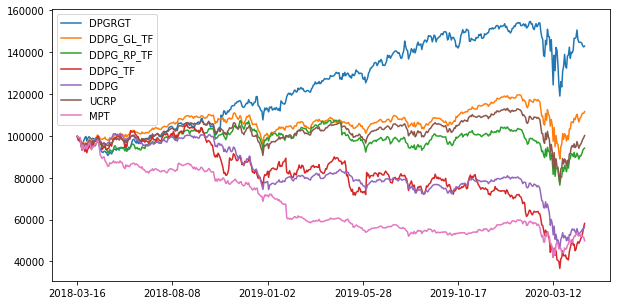

In [0]:
if load_and_merge_results:
    dfs = pd.read_csv(results_file, index_col=0)
    df = pd.DataFrame(data={agent_type:[info['portfolio_value']for info in results[agent_type]]}, 
                      index=[info['date']for info in results[agent_type]])
    dfs[agent_type] = df[agent_type]
    print('{} is updated.'.format(agent_type))
else:
    for i, (model, data) in enumerate(results.items()):
        df = pd.DataFrame(data={model:[info['portfolio_value']for info in data]}, 
                        index=[info['date']for info in data])
        dfs = pd.merge(dfs, df, left_index=True, right_index=True) if i > 0 else df
if save_results:
    dfs.to_csv(results_file)
dfs.plot(figsize=(10, 5))

In [0]:
eval_data = {
    'CR': [np.round((dfs[model][-1])*100/dfs[model][0] - 100, 2) for model in dfs.columns],
    'ASR':[np.round(sharpe_ratio(np.diff(np.array(dfs[model]))),4) for model in dfs.columns]
}
eval_df = pd.DataFrame(data=eval_data, index=dfs.columns)
display(eval_df)

,CR,ASR
DPGRGT,43.16,0.6418
DDPG_GL_TF,11.93,0.2813
DDPG_RP_TF,-5.45,-0.1343
DDPG_TF,-41.71,-0.8191
DDPG,-42.91,-1.2194
UCRP,0.53,0.0125
MPT,-50.07,-1.5840


# References

1. Abdi, F., & Ranaldo, A. (2017). A Simple Estimation of Bid-Ask Spreads from Daily Close, High, and Low Prices. *The Review of Financial Studies, 30*(12), 4437-4480. doi:10.1093/rfs/hhx084
1. Aboussalah, A. M., & Lee, C.-G. (2020). Continuous control with Stacked Deep Dynamic Recurrent Reinforcement Learning for portfolio optimization. *Expert Syst. Appl., 140*. doi:10.1016/j.eswa.2019.112891
1. Bahdanau, D., Cho, K., & Bengio, Y. (2014). Neural Machine Translation by Jointly Learning to Align and Translate. *CoRR, abs/1409.0473*. 
1. Cho, K., van Merriënboer, B., Gulcehre, C., Bougares, F., Schwenk, H., & Bengio, Y. (2014). Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation. doi:10.3115/v1/D14-1179
1. Huang, C.-Z. A., Vaswani, A., Uszkoreit, J., Simon, I., Hawthorne, C., Shazeer, N., Eck, D. (2019). *Music Transformer: Generating Music with Long-Term Structure*. Paper presented at the ICLR.
1. Kaelbling, L. P., Littman, M. L., & Cassandra, A. R. (1998). Planning and acting in partially observable stochastic domains. *Artificial Intelligence*, 101(1), 99-134. doi:10.1016/S0004-3702(98)00023-X
1. Lillicrap, T. P., Hunt, J. J., Pritzel, A., Heess, N. M. O., Erez, T., Tassa, Y., Wierstra, D. (2015). Continuous control with deep reinforcement learning. *CoRR, abs/1509.02971*.
1. Moody, J., & Saffell, M. (2001). Learning to trade via direct reinforcement. *IEEE transactions on neural networks / a publication of the IEEE Neural Networks Council, 12*, 875-889. doi:10.1109/72.935097
1. Parisotto, E., Song, H. F., Rae, J. W., Pascanu, R., Gulcehre, C., Jayakumar, S. M., Hadsell, R. (2019). Stabilizing Transformers for Reinforcement Learning. *ArXiv, abs/1910.06764*. 
1. Shaw, P., Uszkoreit, J., & Vaswani, A. (2018). Self-Attention with Relative Position Representations. 
1. Silver, D., Lever, G., Heess, N., Degris, T., Wierstra, D., & Riedmiller, M. (2014). *Deterministic policy gradient algorithms*. Paper presented at the Proceedings of the 31st International Conference on International Conference on Machine Learning - Volume 32, Beijing, China. 
1. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Polosukhin, I. (2017). *Attention is All you Need*. Paper presented at the NIPS.
1. Zhang, Z., Chen, J., Chen, Z., & Li, W. (2019). *Asynchronous Episodic Deep Deterministic Policy Gradient: Towards Continuous Control in Computationally Complex Environments*.
